In [1]:
#make general imports
import os 
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(28)

In [2]:
#make necessary fastai import
from fastai import *
from fastai.vision import *

In [3]:
# !pip install torch==1.1.0

In [4]:
torch.__version__

'1.5.0'

In [5]:
data_dir = Path('../input/minerals-identification-dataset/minet')

In [6]:
data = (ImageList.from_folder(data_dir)
                .split_by_rand_pct(0.1, seed=28) 
                .label_from_folder()
                .transform(get_transforms(do_flip=True, flip_vert=True, max_rotate=30), size=224)
                .databunch(bs=128)
                .normalize(imagenet_stats))

In [7]:
data

ImageDataBunch;

Train: LabelList (857 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bornite,bornite,bornite,bornite,bornite
Path: ../input/minerals-identification-dataset/minet;

Valid: LabelList (95 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
quartz,malachite,biotite,muscovite,muscovite
Path: ../input/minerals-identification-dataset/minet;

Test: None

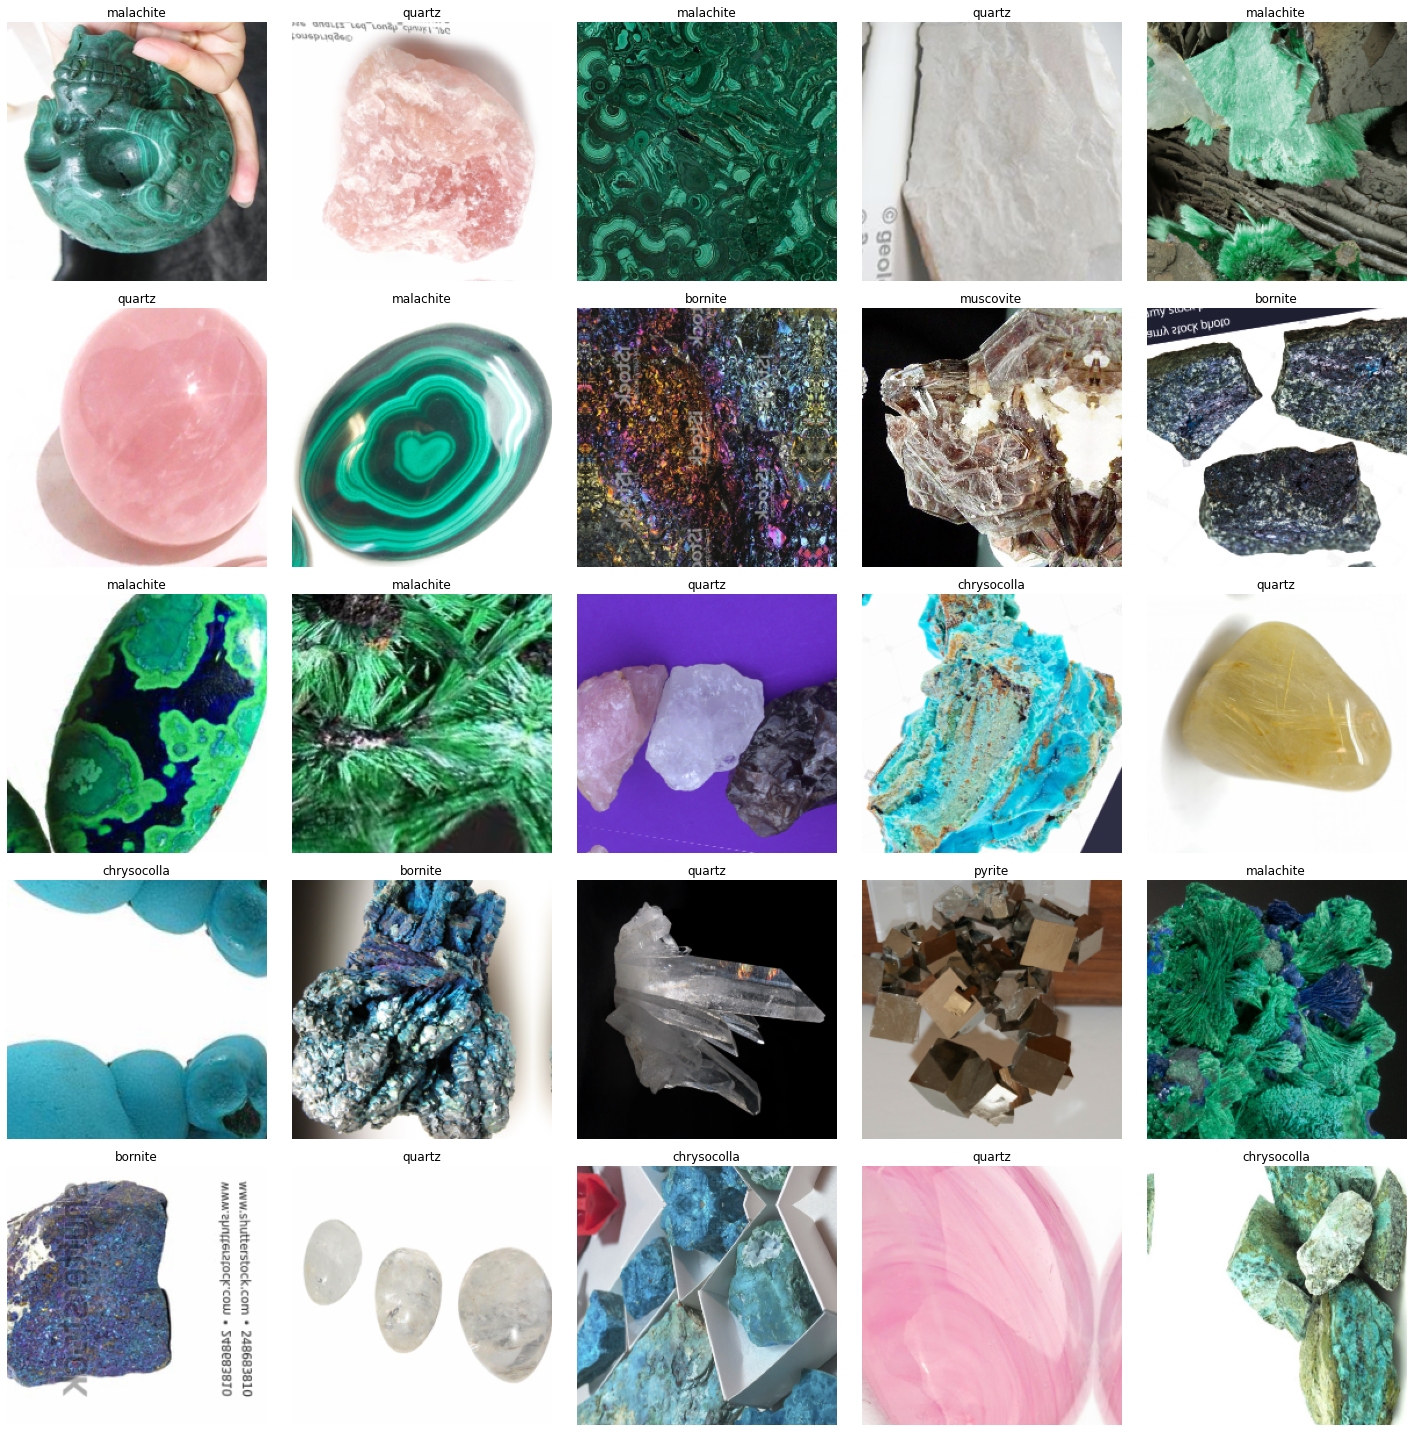

In [8]:
data.show_batch()

In [9]:
data.classes

['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

In [10]:
!mkdir ./models

In [11]:
!ls

__notebook__.ipynb  models


In [12]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.20E-02


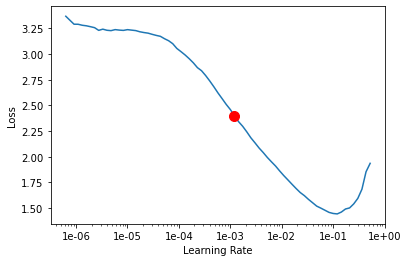

In [13]:
#plot learning rate vs. loss for one epoch to find the range of best learning rates for training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
# fit model for 5 epochs with learning rate slice(1e-2)
learn.fit_one_cycle(5, slice(1e-2))

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 8.32E-05


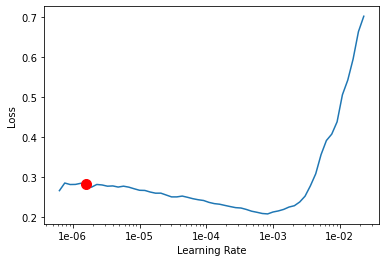

In [16]:
#plot learning rate vs. loss for one epoch to find the range of best learning rates for training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(7, slice(2e-5, 2e-4))

In [18]:
learn.save('/kaggle/working/models/stage2')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

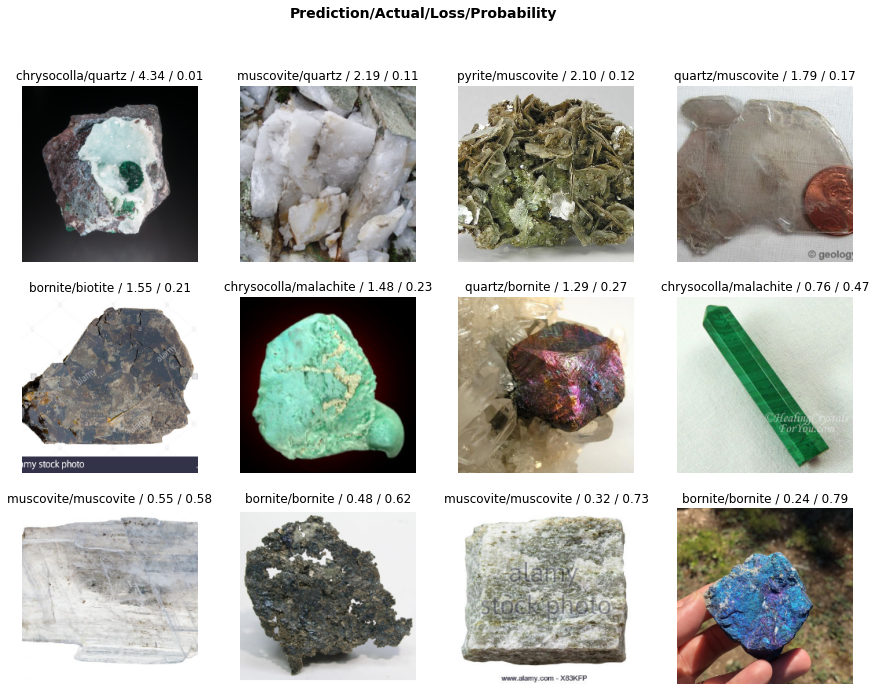

In [20]:
interp.plot_top_losses(12, figsize=(15,11))
plt.savefig('/kaggle/working/top_losses.png')

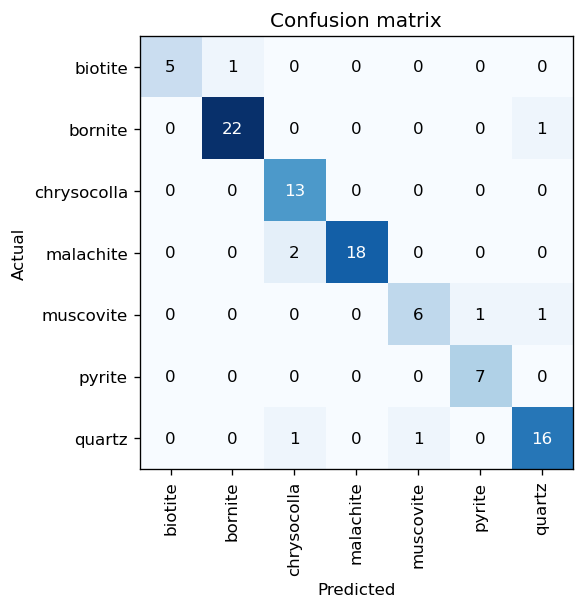

In [21]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=120)
plt.savefig('/kaggle/working/confusion_matrix.png')

In [22]:
interp.most_confused(min_val=1)

[('malachite', 'chrysocolla', 2),
 ('biotite', 'bornite', 1),
 ('bornite', 'quartz', 1),
 ('muscovite', 'pyrite', 1),
 ('muscovite', 'quartz', 1),
 ('quartz', 'chrysocolla', 1),
 ('quartz', 'muscovite', 1)]

In [23]:
data = (ImageList.from_folder(data_dir)
                .split_by_rand_pct(0.1, seed=86) 
                .label_from_folder()
                .transform(get_transforms(do_flip=True, flip_vert=True, max_rotate=10), size=256)
                .databunch(bs=128)
                .normalize(imagenet_stats))

In [24]:
learn.data = data

In [25]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 9.12E-04


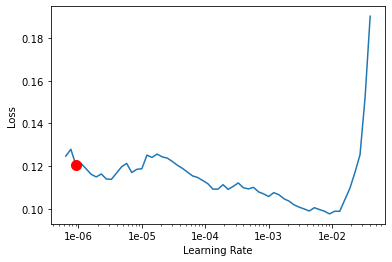

In [26]:
#plot learning rate vs. loss for one epoch to find the range of best learning rates for training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(5, slice(2e-3))

In [28]:
learn.save('/kaggle/working/models/stage3')

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 6.31E-08


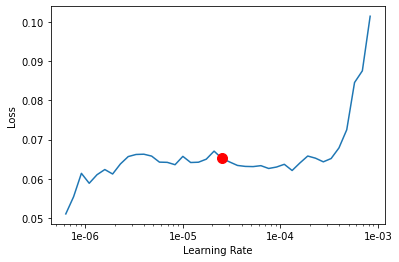

In [30]:
#plot learning rate vs. loss for one epoch to find the range of best learning rates for training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [31]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

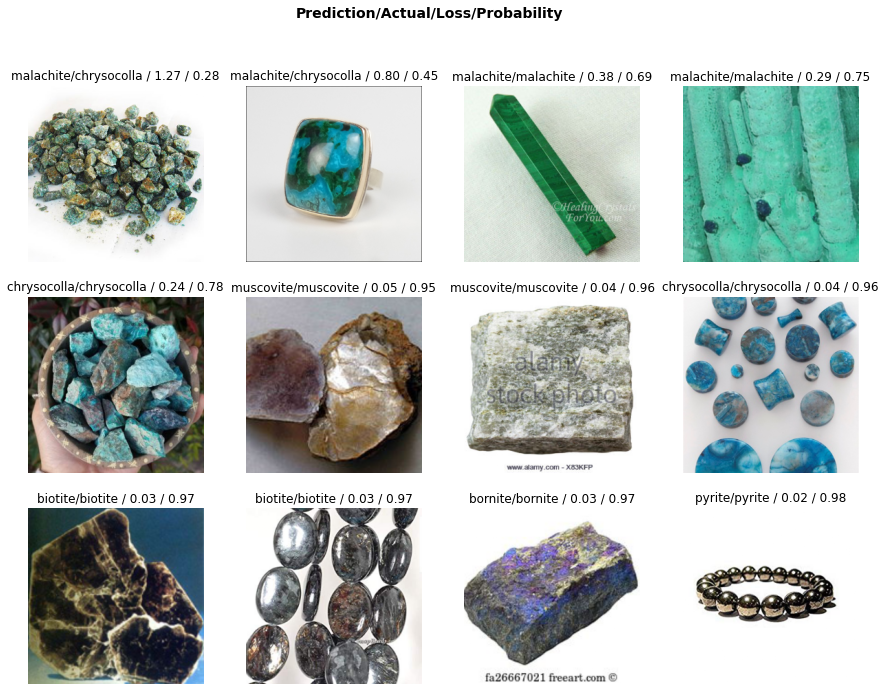

In [33]:
interp.plot_top_losses(12, figsize=(15,11))
plt.savefig('/kaggle/working/top_losses.png')

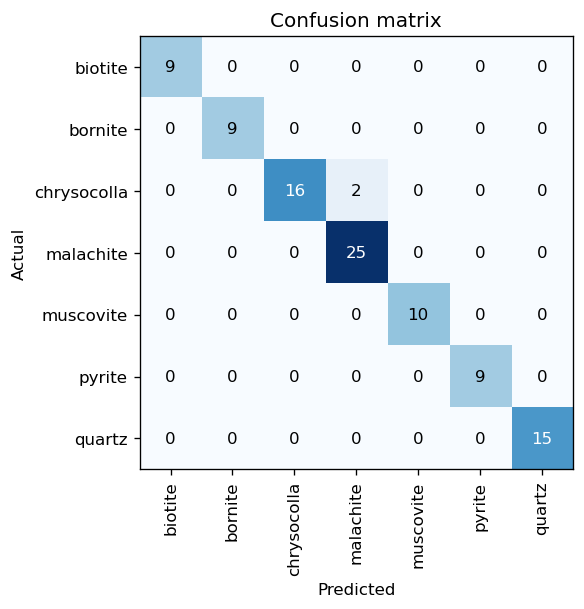

In [34]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=120)
plt.savefig('/kaggle/working/confusion_matrix.png')

In [35]:
learn.save('/kaggle/working/models/stage4')

In [36]:
trace_input = torch.ones(1,3,256,256).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(f'/kaggle/working/models/{model_file}')
torch.jit.save(jit_model, output_path)
# export classes text file
save_texts('/kaggle/working/models/classes.txt', data.classes)
tar_file='/kaggle/working/models/model.tar.gz'
classes_file='classes.txt'
# create a tarfile with the exported model and classes text file
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(f'/kaggle/working/models/{model_file}', arcname=model_file)
    f.add(f'/kaggle/working/models/{classes_file}', arcname=classes_file)